In [1]:
# Load relevant libraries.

%pylab inline
import pylab as pl
import numpy as np
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import geopandas as gp
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
import os

Populating the interactive namespace from numpy and matplotlib


We will use 2 different datasets.

An interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". For example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.

So let's test if the last link holds. If we have data on the energy consumed by a building how well does that relate to the number of units in the building?

In [2]:
# Read LL84 Data

nrg = gp.GeoDataFrame.from_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
print nrg.columns

Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')


In [3]:
nrg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16170 entries, 16099 to 13482
Data columns (total 24 columns):
NYC Borough, Block, and Lot (BBL)                                  16014 non-null float64
Co-reported BBL Status                                             912 non-null object
BBLs Co-reported                                                   13790 non-null object
Reported NYC Building Identificaiton Numbers (BINs)                13790 non-null object
Street Number                                                      14423 non-null object
Street Name                                                        14458 non-null object
Borough                                                            16170 non-null object
Zip Code                                                           14432 non-null float64
DOF Benchmarking Submission Status                                 16170 non-null object
Site EUI(kBtu/ft2)                                                 12204 non-null obje

However this datasets does not have the number of units. We can find that in the Pluto dataset. reading in the Pluto data for manhattan, which will give me the number of units ber building Manhattan/MNMapPLUTO.shp

In [ ]:
#Read PLUTO data to get the number of units 

bsize = gp.GeoDataFrame.from_file("Manhattan/MNMapPLUTO.shp")
print bsize.columns

Pandas scatter_matrix will plot each column against each other. That is a great way to begin inspecting your data (though be careful because it is computationally comsuming for large datasets)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1122c1150>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x131be0110>]], dtype=object)

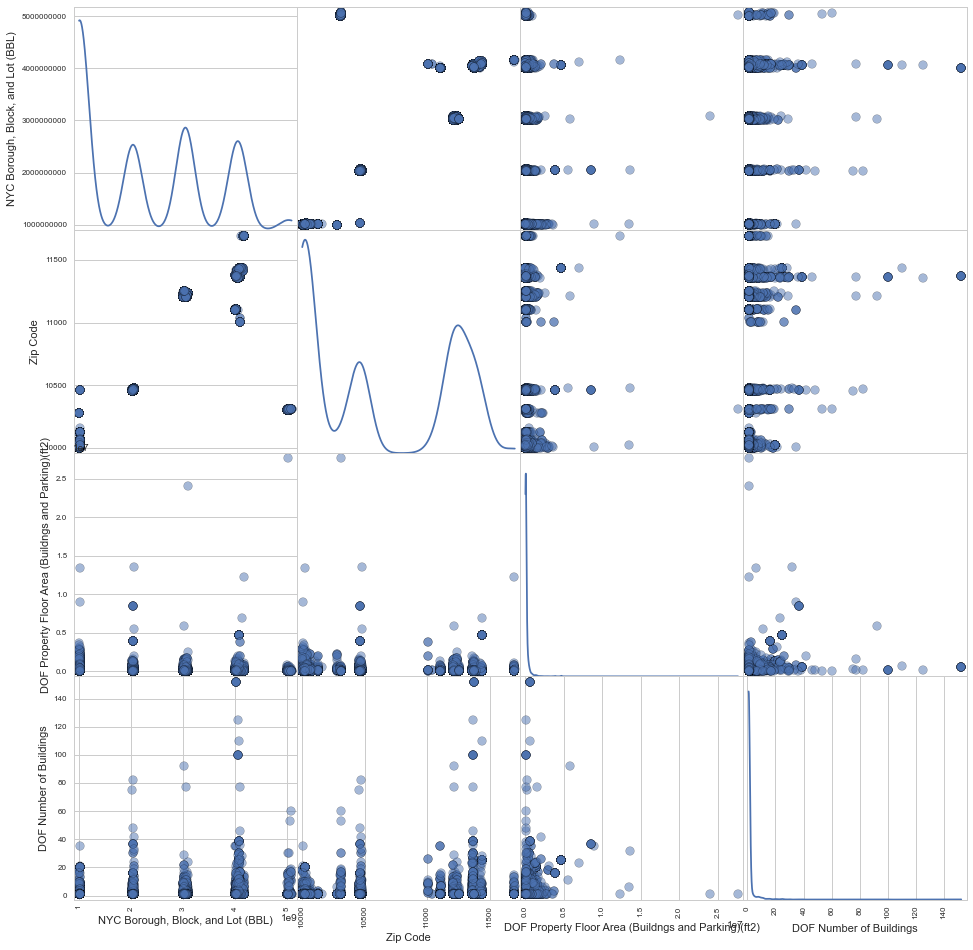

In [5]:
# plot each column against each other using scatter_matrix 

scatter_matrix (nrg, s=300, figsize=(16,16), diagonal='kde')

It will show me correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset! Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: i need to remove all values that cannot conver to float in order to use the columns and convert them to float arrays and do math with them.

Below I created a function that returns True if what is passed as argument can be converted to a float, and False otherwise. I do it with the Try/Except structure. it is a very useful python functionality that you should look into. This has to be done entry by entry: if you give t a series you get error "cannot convert the series to

However you can pass it a whole array by using it in conjunction with np.vectorize (look up the syntax!) which will implement a for loop for you under the hood to pass the series entry by entry to your function.

In [6]:
# Create a function to return true if value is float 

def canconvert(mydata):
    try:
        float(mydata)
        return True
    except ValueError:
        return False
    

Now for every column i care about i can create an array, call it for eg. indx, of True and False (a Boolean array) that i can use as an index to pick entries that I want to use from my arrays of interest. I can replace the entries that failed to be converted to 'NaN'
(because my function return Trues when I can convert and False otherwise i actuallly want the complementary array: ~indx)

In [7]:
#create the index array for Site EUI and Floor Area 

indx1 = np.vectorize(canconvert)(nrg['Site EUI(kBtu/ft2)'])
indx2 = np.vectorize(canconvert)(nrg['Reported Property Floor Area (Building(s)) (ft\xc2\xb2)'])

In [8]:
#use the canconvert function to switch inconvertible values to NaN
nrg.loc[~indx1, 'Site EUI(kBtu/ft2)'] = float('NaN')
nrg.loc[~indx2, 'Reported Property Floor Area (Building(s)) (ft\xc2\xb2)'] = float('NaN')

In [9]:
##check that the conversion works 

print nrg['Site EUI(kBtu/ft2)'].astype(float)
print nrg['Reported Property Floor Area (Building(s)) (ft\xc2\xb2)'].astype(float)

#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want

print bsize.BBL.astype(float)

#notice i can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!

Record Number
16099      180.5
500         82.1
5017       137.7
5116       103.2
363         74.0
6876        36.4
10714      114.8
1214       130.0
1544       138.3
1905     56909.0
2301        88.2
15059       15.7
674          NaN
2537        85.7
2841       195.7
2945        79.1
15120      144.1
3053       200.9
4233       104.6
4777        86.7
4912       102.1
5210        21.2
5295        78.3
1575         NaN
15025       55.2
4208        83.2
4799       145.1
1568        59.4
5427        88.7
5476       100.8
          ...   
14559        NaN
14560        NaN
14748        NaN
14753        NaN
13582        NaN
13947        NaN
14777        NaN
14779        NaN
14409        NaN
13262        NaN
13261        NaN
12523        NaN
12529        NaN
12536        NaN
13929        NaN
13944        NaN
13945        NaN
13821        NaN
13829        NaN
13837        NaN
13838        NaN
13847        NaN
14352        NaN
12976        NaN
12978        NaN
12984        NaN
12987        NaN


TO MERGE THE DATASET WE NEED A COMMON COLUMN

Here is where you want to merge the datasets. You need a common column: the building id BBL. However the name of this variable (column) in the Energy dataset is 'NYC Borough, Block, and Lot (BBL)'. Create a column 'BBL' in the nrg dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value.

In [10]:
#Merge energy data with building data 

nrg['BBL'] = nrg['NYC Borough, Block, and Lot (BBL)']
bblnrgdata = pd.merge(nrg, bsize, how='inner', on=['BBL'])
print bblnrgdata.columns

/Users/Camellia/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1695: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target.values)
/Users/Camellia/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1049: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine


Index([                  u'NYC Borough, Block, and Lot (BBL)',
                                    u'Co-reported BBL Status',
                                          u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
                                             u'Street Number',
                                               u'Street Name',
                                                 u'Borough_x',
                                                  u'Zip Code',
                        u'DOF Benchmarking Submission Status',
                                        u'Site EUI(kBtu/ft2)', 
       ...
                                                u'YearAlter2',
                                                 u'YearBuilt',
                                                    u'ZMCode',
                                                   u'ZipCode',
                                                 u'ZoneDist1',
                                           

Once you have the dataframe with all the info you want, you want to plot Energy vs Number of Units in the Building. Remember: Energy TOTAL, not per sq ft... Here you can choose what you think makes more sense for the number of units: all units, residential units... make a 'natural' scale scatter plot first it will look really bad cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000. Perhaps zoom into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

/Users/Camellia/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1572: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return self._engine.get_loc(_values_from_object(key))


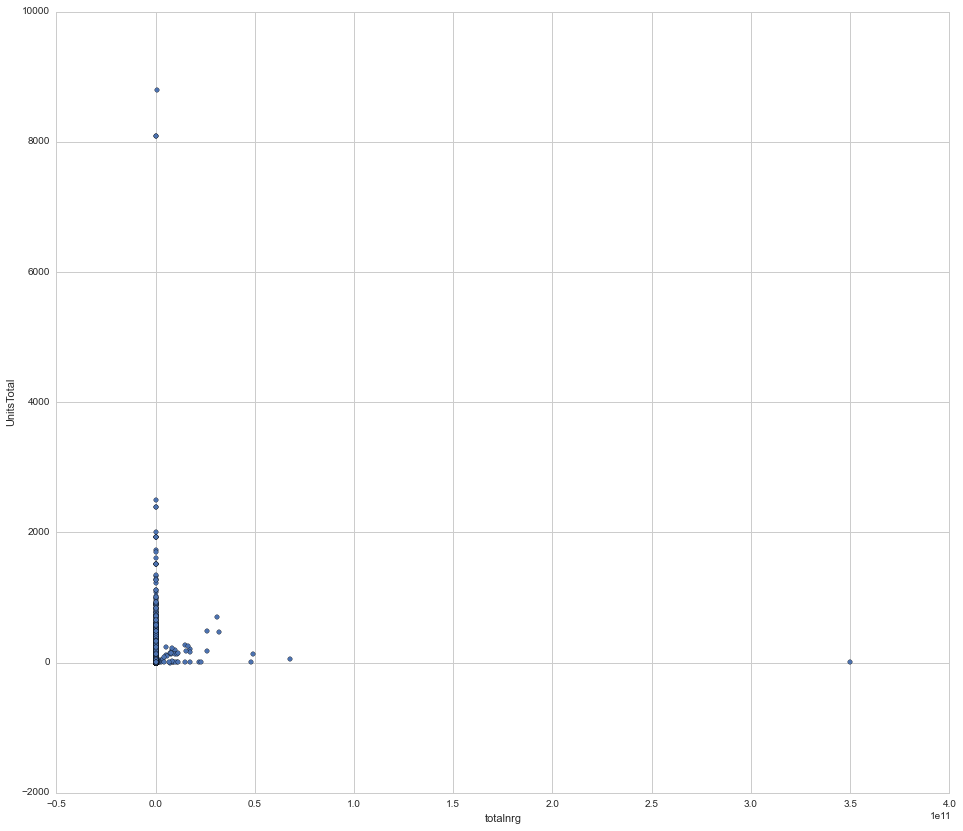

In [11]:
#Total energy
bblnrgdata['totalnrg'] = bblnrgdata['Reported Property Floor Area (Building(s)) (ft\xc2\xb2)'].astype(float)*\
                    bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)
bblnrgdata.plot(kind='scatter', x='totalnrg', y='UnitsTotal', marker='o', figsize=(16,14))

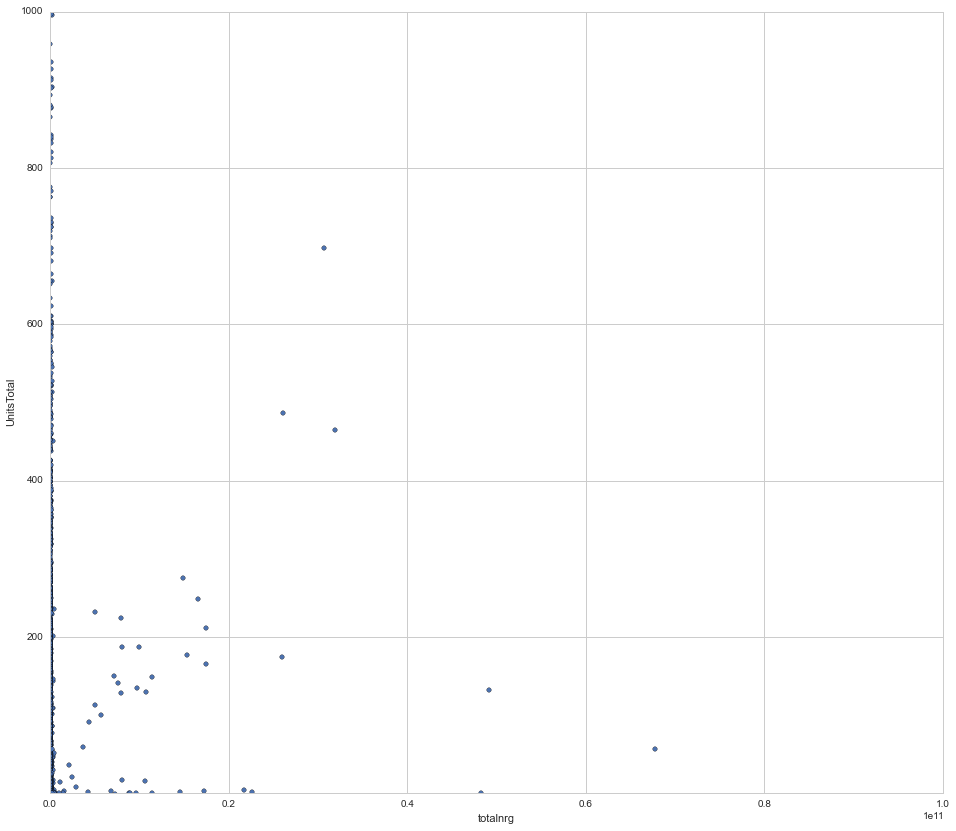

In [12]:
#Zoom

bblnrgdata.plot(kind='scatter',x='totalnrg',y='UnitsTotal', marker='o', figsize=(16, 14),  xlim=(1000,1e11), ylim=(1,1000))

When the points in a plot all look scrunched against the axis try a log plot! In pandas you enable that with the keyword 'loglog' : bblnrgdata.plot(..... loglog=True)

NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data i had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. you can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array: something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000]

Also i removed the buildings with several thousand units. points like that at the edge of my range would have a lot of "LEVERAGE", however they are not suprious entries like the 0, which i believe are missing values, or perhaps abandoned lots. these are good datapoint that i need to throw away functionally for my analysis to work, but that should be stated clearly.

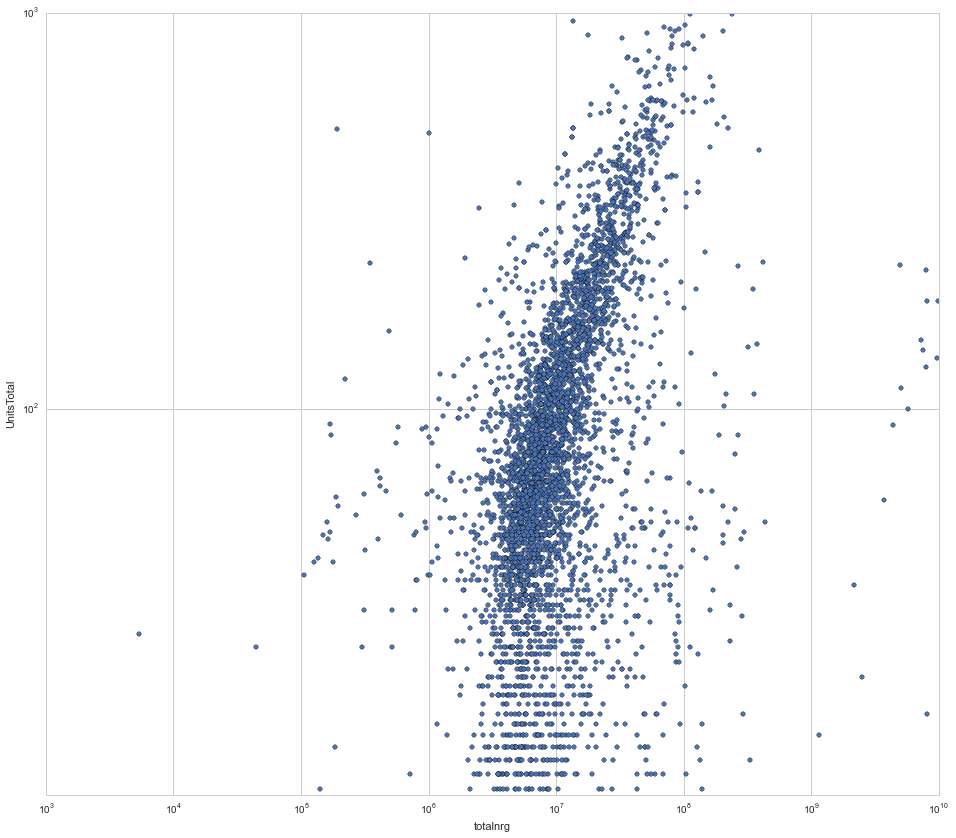

In [13]:
bblnrgdata_clean = bblnrgdata[(bblnrgdata.totalnrg>1000) & (bblnrgdata.totalnrg<1e10) & (bblnrgdata.UnitsTotal>10) \
                            & (bblnrgdata.UnitsTotal<1000)]
bblnrgdata_clean.plot(kind='scatter',x='totalnrg',y='UnitsTotal', marker='o', figsize=(16, 14),  xlim=(1000,1e10), ylim=(0,1000)\
                ,loglog=True)

Now fit a line through the data. you can use whatever you want to do it: statsmodels, scipy, any other package, or write your own minimization of the residuals.

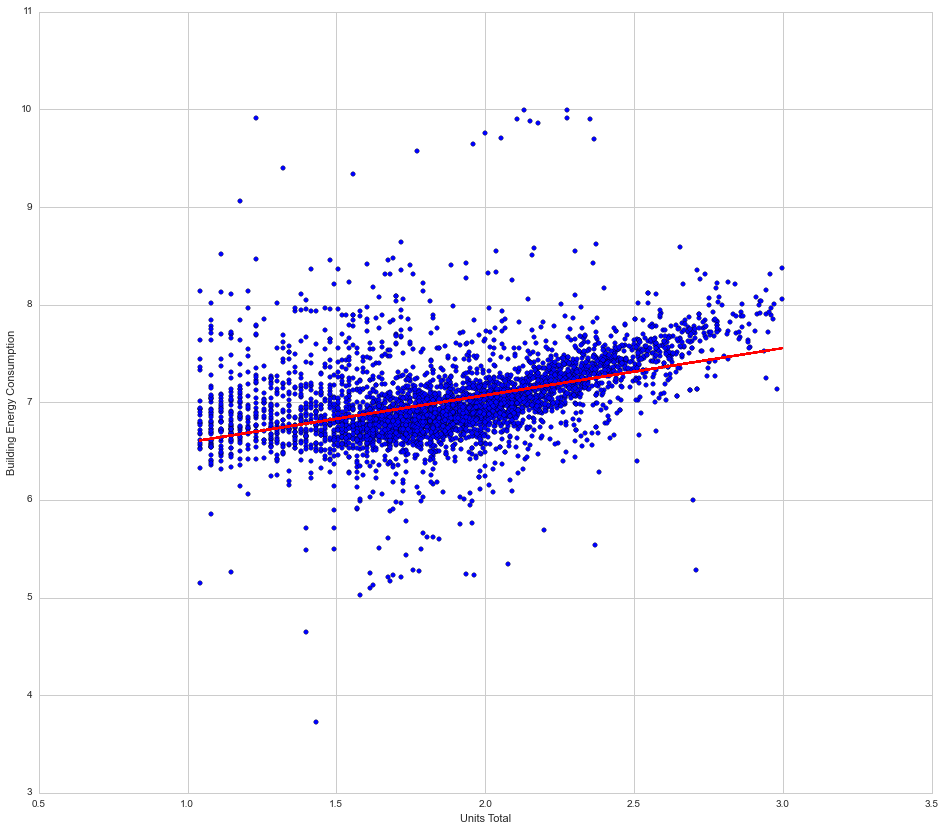

In [14]:
#Fit energy and units 

dt = pd.DataFrame({'totalnrg_log':np.log10(bblnrgdata_clean.totalnrg), 
                  'UnitsTotal_log':np.log10(bblnrgdata_clean.UnitsTotal)})
model1 = smf.ols('totalnrg_log ~ UnitsTotal_log', data=dt).fit()
pl.figure(figsize=(16,14))
pl.scatter(dt.UnitsTotal_log, dt.totalnrg_log)
plot(dt.UnitsTotal_log, model1.predict(), 'r')
pl.ylabel('Building Energy Consumption')
pl.xlabel('Units Total')

In [15]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           totalnrg_log   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     931.2
Date:                Wed, 14 Oct 2015   Prob (F-statistic):          6.73e-185
Time:                        12:52:24   Log-Likelihood:                -2113.1
No. Observations:                4202   AIC:                             4230.
Df Residuals:                    4200   BIC:                             4243.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          6.1064      0.031    199.843      0.000         6.046     6.166
UnitsTotal_log     0.4825      0.016     30.515      0.000         0.451     0.513
==============================================================================
Omnibus:                     1449.500   Durbin-Watson:                   1.588
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22731.456
Skew:                           1.215   Prob(JB):                         0.00
Kurtosis:                      14.132   Cond. No.                         12.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

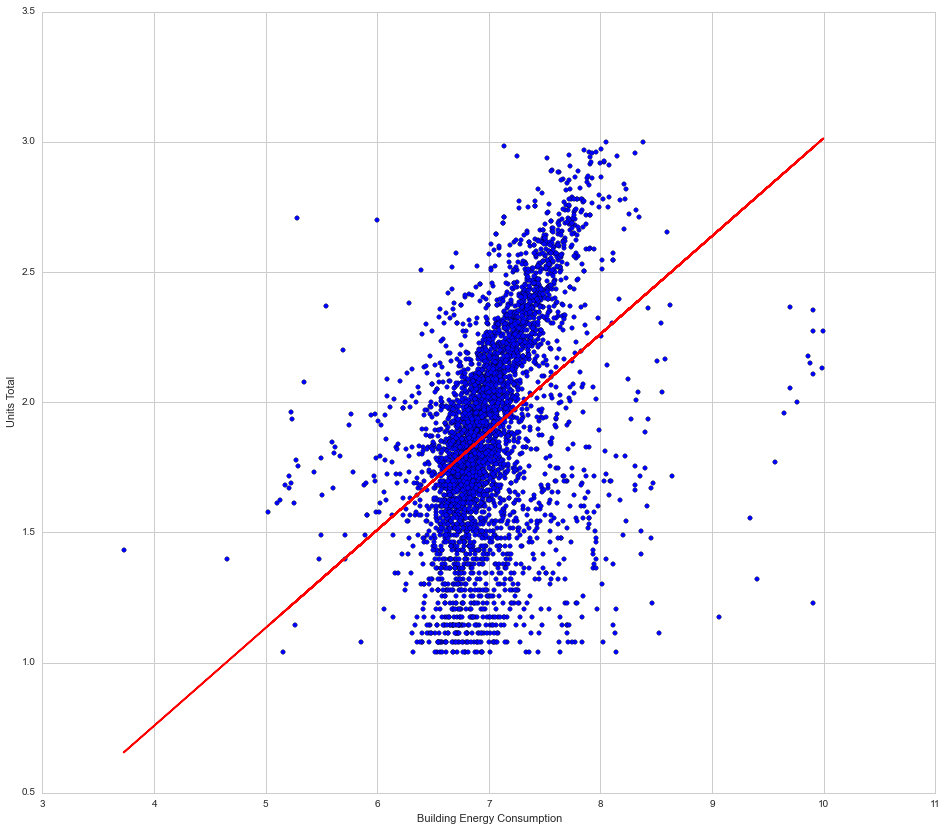

In [16]:
#Fit units and energy 

model2 = smf.ols('UnitsTotal_log ~ totalnrg_log', data=dt).fit()
pl.figure(figsize=(16,14))
pl.scatter(dt.totalnrg_log, dt.UnitsTotal_log)
plot(dt.totalnrg_log, model2.predict(), 'r')
pl.xlabel('Building Energy Consumption')
pl.ylabel('Units Total')

In [17]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         UnitsTotal_log   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     931.2
Date:                Wed, 14 Oct 2015   Prob (F-statistic):          6.73e-185
Time:                        12:52:25   Log-Likelihood:                -1590.0
No. Observations:                4202   AIC:                             3184.
Df Residuals:                    4200   BIC:                             3197.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       -0.7476      0.087     -8.623      0.000        -0.918    -0.578
totalnrg_log     0.3761      0.012     30.515      0.000         0.352     0.400
==============================================================================
Omnibus:                      187.221   Durbin-Watson:                   1.337
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              215.500
Skew:                          -0.514   Prob(JB):                     1.60e-47
Kurtosis:                       3.415   Cond. No.                         114.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* It is difficult to decide which one is better because fitting linear regression is applied to the same data. 

* R squared value of both models is 0.181 

* Likelihood ratio test cannot be carried out here because two models have the same degree of freedom. We only change the dependent variable and the independent variable. 

#now fit a second degree curve to it: ax^2+bx+c.

that is still called a linear fir by the way, the "linear" definition refers to the PARAMETERS being linear, not to the variable! you can use np.polyfit for example (an example showned in the other assignment notebook), with order 2 instead of 1,
np.polyfit(x, y, 2)
or statmodels.formula.api passing a formula like
formula = 'y ~ 1 + x + I(x ^ 2.0)'

In [18]:
UnitsTotal = np.log10(bblnrgdata_clean['UnitsTotal'])
totalnrg = np.log10(bblnrgdata_clean['totalnrg'])
mod = np.polyfit(UnitsTotal, totalnrg, 2)
print mod

[ 0.5657754  -1.68605426  8.09772105]


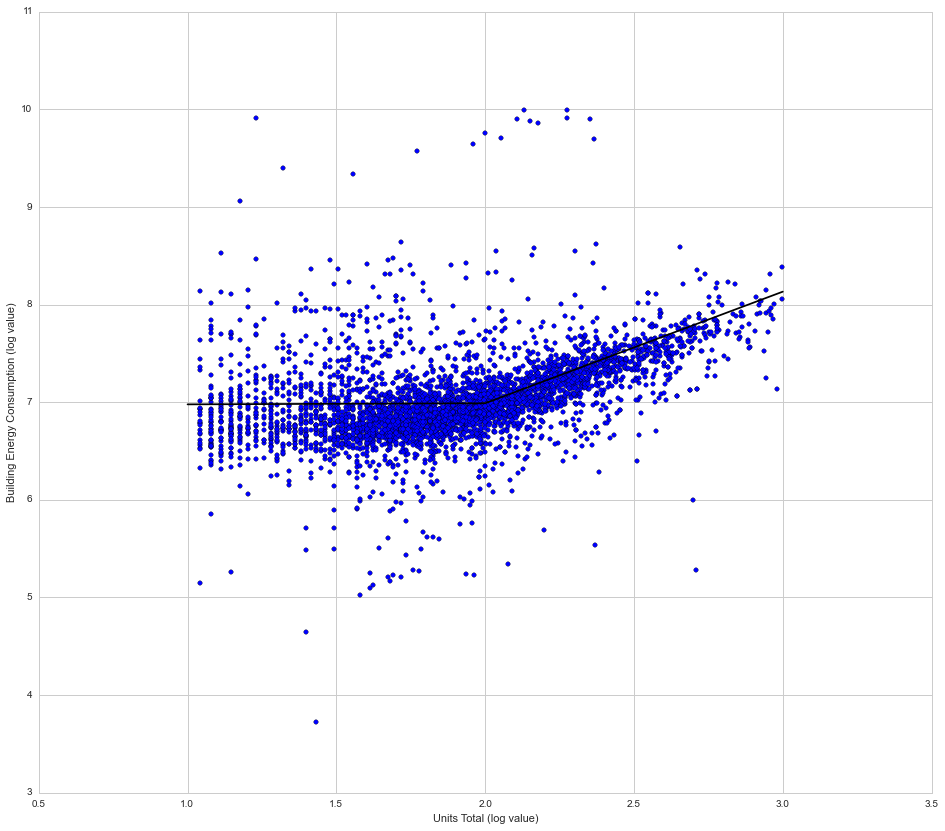

In [ ]:
x = np.arange(1,4)
y = 0.5657754*x**2 - 1.68605426*x + 8.09772105 

pl.figure(figsize=(16,14))
pl.scatter(UnitsTotal, totalnrg)
pl.plot(x, y, 'k')
pl.xlabel('Units Total (log value)')
pl.ylabel('Building Energy Consumption (log value)')

This model appears to be the best fit. Again, a likelihood ratio could not be taken among these models because the difference in degrees of freedom is zero. 